In [17]:
!pip install unicodecsv

In [ ]:
#import the required packages 
import unicodecsv
from datetime import datetime as dt

In [ ]:
#Functions to read the csv files and return lists of records
def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)


In [86]:
enrollments = read_csv('/content/enrollments.csv')
daily_engagement = read_csv('/content/daily_engagement.csv')
project_submissions = read_csv('/content/project_submissions.csv')


In [23]:
#Function to convert the date to a specific format that can be used easily
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')

In [24]:
#Making changes to the records in the enrollments list
for data in enrollments:
  data['is_canceled']=data['is_canceled']=='True'
  data['is_udacity']=data['is_udacity']=='True'
  if data['days_to_cancel']=='':
    data['days_to_cancel']=None
  else:
    data['days_to_cancel']=int(data['days_to_cancel'])
  data['join_date']=parse_date(data['join_date'])
  data['cancel_date']=parse_date(data['cancel_date'])


#Making changes to the records in the daily_engagement lists
for data in daily_engagement:
  data['account_key'] = int(data['acct'])
  data['utc_date'] = parse_date(data['utc_date'])
  data['num_courses_visited'] = float(data['num_courses_visited'])
  data['total_minutes_visited'] = float(data['total_minutes_visited'])
  data['lessons_completed'] = float(data['lessons_completed'])
  data['projects_completed'] = float(data['projects_completed'])
  del(data['acct']) 


#Making changes to the records in the project_submissions lists
for data in project_submissions:
  data['creation_date'] = parse_date(data['creation_date'])
  data['completion_date'] = parse_date(data['completion_date'])
  data['account_key'] = int(data['account_key'])
  data['lesson_key'] = int(data['lesson_key'])

In [85]:
#Finding the otal number of unique enrollment, daily_engagement and project_submission recods 

unique_enrollments = set()
unique_student_engagement = set()
unique_project_submissions = set()

for i in enrollments:
  unique_enrollments.add(i['account_key'])
for i in daily_engagement:
  unique_student_engagement.add(i['account_key'])
for i in project_submissions:
  unique_project_submissions.add(i['account_key'])
  
print('Num of unique_enrollments:',len(unique_enrollments),'\nNum of unique_student_engagement:',len(unique_student_engagement),'\nNum of unique_project_submissions:',len(unique_project_submissions))

Num of unique_enrollments: 1302 
Num of unique_student_engagement: 1237 
Num of unique_project_submissions: 743


In [84]:
'''
Creating lists for recods that do not belong to the udacity test accounts. This is done by checking the 
'is_udacity' field in the enrollments records and keeping all those accounts that have a value 'False'
'''

non_udacity_enrollments = list()
non_udacity_engagements = list()
non_udacity_submissions = list()
non_udacity_accounts = set()


for data in enrollments:
  if data['is_udacity']:
    non_udacity_accounts.add(data['account_key']) 


def remove_udacity_accounts(list1):
  list2 = []
  for data in list1:
    if data['account_key'] not in non_udacity_accounts:
      list2.append(data) 
  return list2    

non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagements = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print('Num of non_udacity_enrollments:',len(non_udacity_enrollments),'\nNum of non_udacity_engagements:',len(non_udacity_engagements),'\nNum of non_udacity_submissions:',len(non_udacity_submissions))

Num of non_udacity_enrollments: 1622 
Num of non_udacity_engagements: 136240 
Num of non_udacity_submissions: 3642


In [82]:
#Creating a list of those students who have paid for the courses by being enrolled for more than 7 days
paid_students = {}
for data in non_udacity_enrollments:
  if not data['is_canceled'] or data['days_to_cancel']>7:
    account_key = int(data['account_key'])
    enrollment_date = (data['join_date'])
    if (account_key not in paid_students) or (enrollment_date < paid_students[account_key]):
      paid_students[account_key] = data['join_date']

print('Num of paid enrollments:',len(paid_students))

Num of paid enrollments: 995


In [ ]:
#Creating a list of a week's data for students who have paid for the courses they have enrolled.

paid_engagement_in_first_week = list()

for i in non_udacity_engagements:
  account_key = i['account_key']
  if account_key in paid_students:
    diff_days = i['utc_date'] - paid_students[account_key]  
    if diff_days.days < 7 and diff_days.days >= 0:
      if account_key == 168:
        print(diff_days,i['utc_date'],paid_students[account_key])
      paid_engagement_in_first_week.append(i)

#Creating a field 'has_visited' if the student has visited 1 or more courses on that particular day
for engagement_record in paid_engagement_in_first_week:
    if engagement_record['num_courses_visited'] > 0:
        engagement_record['has_visited'] = 1 
    else:
        engagement_record['has_visited'] = 0 



In [78]:
'''
Creating utility functions that help in finsing the mean, std deviation, max and min for different records
such as:

--The total minutes spent by the student in the first week
--Total courses completed by the student in the first week
--Total days visited by the student in the first week

These metrics help to analyse the patterns for students who pass the first project and those who don't
'''

from collections import defaultdict
import numpy as np

def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data


def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data


def describe_data(data):
    data=list(data)
    print('Mean:', np.mean(data))
    print('Standard deviation:', np.std(data))
    print('Minimum:', np.min(data))
    print('Maximum:', np.max(data))


In [77]:
#Printing various statistics for all paid engagements during the first week

print('Statistics for total mintes vsted by students during the first week')
engagement_by_account = group_data(paid_engagement_in_first_week,
                                   'account_key')
total_minutes_by_account = sum_grouped_items(engagement_by_account,
                                             'total_minutes_visited')

describe_data(total_minutes_by_account.values())

print('\nStatistics for total lessons completed by the student during the first week')
lessons_completed_by_account = sum_grouped_items(engagement_by_account,
                                                'lessons_completed')
describe_data(lessons_completed_by_account.values())

print('\nStatistics for total days visited by students during the first week')
days_visited_by_account = sum_grouped_items(engagement_by_account,
                                            'has_visited')
describe_data(days_visited_by_account.values())

Statistics for total mintes vsted by students during the first week
Mean: 328.6152716651489
Standard deviation: 412.7251965631992
Minimum: 0.0
Maximum: 3564.7332644989997

Statistics for total lessons completed by the student during the first week
Mean: 1.693467336683417
Standard deviation: 3.0227791029472386
Minimum: 0.0
Maximum: 36.0

Statistics for total days visited by students during the first week
Mean: 3.1125628140703516
Standard deviation: 2.1921268360087813
Minimum: 0
Maximum: 7


In [81]:
'''
Creating a list of students who pass the project v/s who donot pass the project. The project considered 
is the subway project which can be looked up by the project key as shown in the code below.Printing out 
the number of students who pass and those who do not pass.
'''

proj_pass=[]
passing_engagement = []
non_passing_engagement = []
for data in non_udacity_submissions:
  if data['account_key'] in paid_students:
    if data['lesson_key'] in [746169184,3176718735]:
      account_key = data['account_key']
      if data['assigned_rating'] in ['PASSED','DISTINCTION']:
        proj_pass.append(account_key)

for data in paid_engagement_in_first_week:
  if data['account_key'] in proj_pass:   
        passing_engagement.append(data)
  else:
        non_passing_engagement.append(data)
print('Num of passing_engagement:',len(passing_engagement),'\nNum of non-passing_engagement:',len(non_passing_engagement)) 

Num of passing_engagement: 4528 
Num of non-passing_engagement: 2392


In [63]:
#Stats for mintes spent by both groups of students

passing_engagement_by_account = group_data(passing_engagement,'account_key')
total_minutes_by_account_p = sum_grouped_items(passing_engagement_by_account,'total_minutes_visited')
print('Passing students minutes spent:')
describe_data(total_minutes_by_account_p.values())

non_passing_engagement_by_account = group_data(non_passing_engagement,'account_key')
total_minutes_by_account_np = sum_grouped_items(non_passing_engagement_by_account,'total_minutes_visited')
print('\nNon-Passing students minutes spent:')
describe_data(total_minutes_by_account_np.values())

Passing students minutes spent:
Mean: 419.90178790493724
Standard deviation: 443.88042682080544
Minimum: 0.0
Maximum: 3564.7332644989997

Non-Passing students minutes spent:
Mean: 158.89580038025503
Standard deviation: 276.45353327459617
Minimum: 0.0
Maximum: 1768.5227493319999


In [52]:
#Stats for courses completed by both groups of students

passing_engagement_by_account = group_data(passing_engagement,'account_key')
total_lessons_by_account_p = sum_grouped_items(passing_engagement_by_account,'lessons_completed')
print('Passing students lessons completed:')
describe_data(total_lessons_by_account_p.values())

non_passing_engagement_by_account = group_data(non_passing_engagement,'account_key')
total_lessons_by_account_np = sum_grouped_items(non_passing_engagement_by_account,'lessons_completed')
print('\nNon-Passing students lessons completed:')
describe_data(total_lessons_by_account_np.values())

Passing students lessons completed:
Mean: 2.123647604327666
Standard deviation: 3.158880955295347
Minimum: 0.0
Maximum: 36.0

Non-Passing students lessons completed:
Mean: 0.8936781609195402
Standard deviation: 2.566957416705277
Minimum: 0.0
Maximum: 27.0


In [53]:
#Stats for total days visited for both groups of students

passing_engagement_by_account = group_data(passing_engagement,'account_key')
total_days_visited_by_account_p = sum_grouped_items(passing_engagement_by_account,'has_visited')
print('Passing students days visited:')
describe_data(total_days_visited_by_account_p.values())

non_passing_engagement_by_account = group_data(non_passing_engagement,'account_key')
total_days_visited_by_account_np = sum_grouped_items(non_passing_engagement_by_account,'has_visited')
print('\nNon-Passing students days visited:')
describe_data(total_days_visited_by_account_np.values())

Passing students days visited:
Mean: 3.6723338485316845
Standard deviation: 2.1318714797122227
Minimum: 0
Maximum: 7

Non-Passing students days visited:
Mean: 2.07183908045977
Standard deviation: 1.9037199088485366
Minimum: 0
Maximum: 7


Text(0.5, 1.0, 'Histogram of total minutes spent on udacity for students who pass v/s those who dont pass')

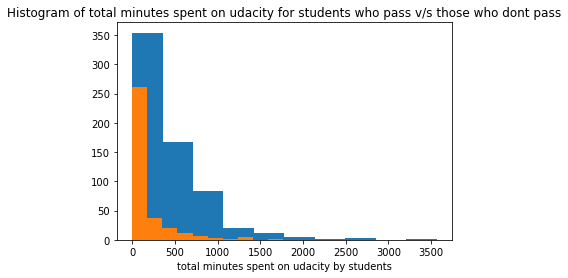

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(total_minutes_by_account_p.values())
plt.hist(total_minutes_by_account_np.values())
plt.xlabel('total minutes spent on udacity by students')
plt.title('Histogram of total minutes spent on udacity for students who pass v/s those who dont pass')

Text(0.5, 1.0, 'Histogram of total total lessons completed for students who pass v/s those who dont pass')

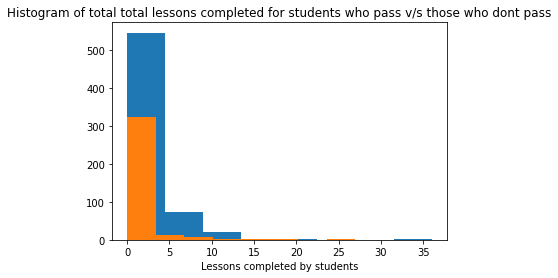

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(total_lessons_by_account_p.values(),bins=8)
plt.hist(total_lessons_by_account_np.values(),bins=8)
plt.xlabel('Lessons completed by students')
plt.title('Histogram of total total lessons completed for students who pass v/s those who dont pass')

Text(0.5, 1.0, 'Histogram of total days visited for students who pass v/s those who dont pass')

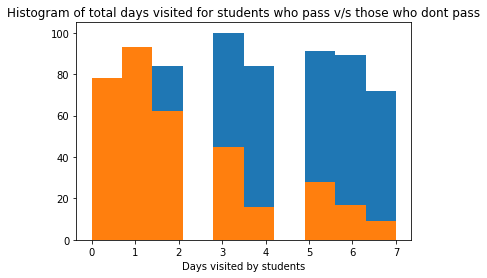

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(total_days_visited_by_account_p.values(),bins=10)
plt.hist(total_days_visited_by_account_np.values(),bins=10)
plt.xlabel('Days visited by students')
plt.title('Histogram of total days visited for students who pass v/s those who dont pass')